# Result visualisations for reinforcement costs

In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

In [ ]:
from edisgo.edisgo import import_edisgo_from_files
from edisgo.flex_opt.costs import line_expansion_costs

In [1]:
def load_costs_per_voltage_level(res_dir, tariffs, penetrations,  grid_ids, modes, grid_values=None):
    def _get_tariff(tariff):
        try:
            return rename_dict[tariff]
        except:
            return tariff
    reinforcement_costs = pd.DataFrame()
    for grid_id in grid_ids:
        for tariff in tariffs:
            for penetration in penetrations:
                for mode in modes:
                    try:
                        res_dir_tmp = os.path.join(res_dir, str(grid_id), tariff, str(penetration), mode)
                        grid_expansion_costs_tmp = \
                            pd.read_csv(f"{res_dir_tmp}/grid_expansion_results/grid_expansion_costs.csv", 
                                        index_col=0)
                        if grid_values is not None:
                            try:
                                relative_costs = grid_expansion_costs_tmp.total_costs.sum()/1e3/grid_values.loc[grid_id, "costs"]*100
                            except:
                                relative_costs = None
                        else:
                            relative_costs = None
                        reinforcement_costs = pd.concat([reinforcement_costs, pd.DataFrame({
                            "grid_id": [grid_id],
                            "tariff": [_get_tariff(tariff)],
                            "penetration": [penetration],
                            "mode": [mode],
                            "costs": [grid_expansion_costs_tmp.total_costs.sum()/1e3],
                            "costs_lv": [grid_expansion_costs_tmp.loc[grid_expansion_costs_tmp.voltage_level=="lv"].total_costs.sum()/1e3],
                            "costs_mv": [grid_expansion_costs_tmp.loc[grid_expansion_costs_tmp.voltage_level=="mv"].total_costs.sum()/1e3],
                            "costs_mvlv": [grid_expansion_costs_tmp.loc[grid_expansion_costs_tmp.voltage_level=="mv/lv"].total_costs.sum()/1e3],
                            "relative_costs_percent": [relative_costs]
                        })])
                    except:
                        print(f"Could not load results for grid {grid_id}, tariff {_get_tariff(tariff)}, penetration {penetration}, {mode}.")
                        continue
    return reinforcement_costs

In [2]:
def get_transformer_costs(edisgo_obj):
    hvmv_trafos = edisgo_obj.topology.transformers_hvmv_df.index
    mvlv_trafos = edisgo_obj.topology.transformers_df.index
    costs_trafos = pd.DataFrame(
        {
            "costs": len(hvmv_trafos)
                                  * [float(edisgo_obj.config["costs_transformers"]["mv"])],
            "voltage_level": len(hvmv_trafos)
                                  * ["hv/mv"],
        },
        index=hvmv_trafos,
    )
    costs_trafos = pd.concat([costs_trafos,
        pd.DataFrame(
            {
                "costs": len(mvlv_trafos)
                                      * [float(edisgo_obj.config["costs_transformers"]["lv"])],
                "voltage_level": len(mvlv_trafos)
                                 * ["mv/lv"],
            },
            index=mvlv_trafos,
        )]
    )
    return costs_trafos


def get_line_costs(edisgo_obj):
    lines = edisgo_obj.topology.lines_df
    costs_lines = line_expansion_costs(edisgo_obj, lines.index)
    costs_lines["costs"] = costs_lines.apply(
        lambda x: x.costs_earthworks
                  + x.costs_cable * lines.loc[x.name, "num_parallel"],
        axis=1,
    )

    return costs_lines[["costs", "voltage_level"]]

def get_grid_value(edisgo_obj):
    trafo_costs = get_transformer_costs(edisgo_obj)
    line_costs = get_line_costs(edisgo_obj)
    total_costs = pd.concat([trafo_costs, line_costs])
    return total_costs

In [ ]:
res_dir_base = r"H:\dynamic-tariffs-in-distribution-grids\output\grid_reinforcement_results"

In [ ]:
grids = [grid for grid in os.listdir(res_dir_base) if not grid.endswith("zip")]
grids

In [ ]:
grid_values = pd.DataFrame(index=grids, columns=["costs", "costs_wo_hv"])
for grid_id in grids:
    if os.path.isdir(
            r"output\grid_reinforcement_results\{}\base\topology".format(grid_id)):
        edisgo_obj = import_edisgo_from_files(
            r"output\grid_reinforcement_results\{}\base".format(grid_id))
        grid_value_tmp = get_grid_value(edisgo_obj)
        grid_values.loc[grid_id, "costs"] = grid_value_tmp.costs.sum()/1e3
        grid_values.loc[grid_id, "costs_wo_hv"] = grid_value_tmp.loc[grid_value_tmp.voltage_level.isin(["mv", "mv/lv", "lv"])].costs.sum()/1e3
grid_values

In [ ]:
tariffs = os.listdir(os.path.join(res_dir_base, grids[-1]))
tariffs

In [ ]:
penetrations = [0.0, 0.25, 0.5, 0.75, 1.0]
modes = ["load", "feed-in", "debug"]

In [ ]:
rename_dict ={
    '00_pricing_constant_operation_dynamic_fi_dynamic_ne_peak_gridch_False_HPnew.pkl': "Constant Peak_DynFeed",
    '00_pricing_constant_operation_dynamic_fi_dynamic_ne_rotating_gridch_False_HPnew.pkl': "Constant Rotating_DynFeed",
    '00_pricing_constant_operation_dynamic_fi_dynamic_ne_segmented_gridch_False_HPnew.pkl': "Constant Segmented_DynFeed",
    '00_pricing_constant_operation_dynamic_fi_dynamic_ne_volumetric_gridch_False_HPnew.pkl': "Constant Volumetric_DynFeed",
    '00_pricing_constant_operation_dynamic_fi_fit_ne_peak_gridch_False_HPnew.pkl': "Constant Peak_FIT",
    '00_pricing_constant_operation_dynamic_fi_fit_ne_rotating_gridch_False_HPnew.pkl': "Constant Rotating_FIT",
    '00_pricing_constant_operation_dynamic_fi_fit_ne_segmented_gridch_False_HPnew.pkl': "Constant Segmented_FIT",
    '00_pricing_constant_operation_dynamic_fi_fit_ne_volumetric_gridch_False_HPnew.pkl': "Constant Volumentric_FIT",
    '00_pricing_dynamic_operation_dynamic_fi_dynamic_ne_peak_gridch_False_HPnew.pkl': "Dynamic Peak_DynFeed",
    '00_pricing_dynamic_operation_dynamic_fi_dynamic_ne_rotating_gridch_False_HPnew.pkl': "Dynamic Rotating_DynFeed",
    '00_pricing_dynamic_operation_dynamic_fi_dynamic_ne_segmented_gridch_False_HPnew.pkl': "Dynamic Segmented_DynFeed",
    '00_pricing_dynamic_operation_dynamic_fi_dynamic_ne_volumetric_gridch_False_HPnew.pkl': "Dynamic Volumetric_DynFeed",
    '00_pricing_dynamic_operation_dynamic_fi_fit_ne_peak_gridch_False_HPnew.pkl': "Dynamic Peak_FIT",
    '00_pricing_dynamic_operation_dynamic_fi_fit_ne_rotating_gridch_False_HPnew.pkl': "Dynamic Rotating_FIT",
    '00_pricing_dynamic_operation_dynamic_fi_fit_ne_segmented_gridch_False_HPnew.pkl': "Dynamic Segmented_FIT",
    '00_pricing_dynamic_operation_dynamic_fi_fit_ne_volumetric_gridch_False_HPnew.pkl': "Dynamic Volumetric_FIT",
    "base": "Base"
}

In [ ]:
tariffs_tmp = ["Peak_DynFeed", "Rotating_DynFeed", "Segmented_DynFeed", "Volumetric_DynFeed", "Peak_FIT",
 "Rotating_FIT", "Segmented_FIT", "Volumetric_FIT",]
results_tmp = load_costs_per_voltage_level(r"H:\dynamic-tariffs-in-distribution-grids\output\grid_reinforcement_results",
                                           tariffs_tmp, penetrations, grids, modes, grid_values)
results_tmp

# Analysis

In [ ]:

# Filter the DataFrame for mode == "feed-in"
df_filtered = results_tmp[results_tmp['mode'] == "feed-in"]

# Define the order of tariffs
tariff_order = ["Volumetric_FIT", "Volumetric_DynFeed", "Peak_FIT", "Peak_DynFeed", 
                "Rotating_FIT", "Rotating_DynFeed", "Segmented_DynFeed", "Segmented_FIT"]

# Define a paired color palette
paired_colors = ["#1f77b4", "#aec7e8",  # Blue shades
                 "#ff7f0e", "#ffbb78",  # Orange shades
                 "#2ca02c", "#98df8a",  # Green shades
                 "#d62728", "#ff9896"]  # Red shades

# Create a box plot for each penetration level
penetration_levels = [0.00, 0.25, 0.50, 0.75, 1.00]

# Create subplots
fig, axes = plt.subplots(1, len(penetration_levels), figsize=(25, 6), sharey=True)

for ax, level in zip(axes, penetration_levels):
    df_level = df_filtered[df_filtered['penetration'] == level]
    
    sns.boxplot(x='tariff', y='costs', data=df_level, order=tariff_order, ax=ax, palette=paired_colors)
    ax.set_title(f'Penetration Level {level}')
    ax.set_xlabel('Tariff')
    ax.set_ylabel('Costs')
    ax.set_ylim(0, 5)  # Set the y-axis limit
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Results absolute values

In [15]:
results_tmp.groupby(["tariff", "penetration", "mode"]).sum().reset_index()

,tariff,penetration,mode,grid_id,costs,costs_lv,costs_mv,costs_mvlv,relative_costs_percent
0,Peak_DynFeed,0.00,debug,3110531133311803135831760319723311133128341863...,15.454719,13.734719,0.0,1.72,26.217839
1,Peak_DynFeed,0.00,feed-in,3110531133311803135831760319723311133128341863...,14.223059,12.503059,0.0,1.72,23.303150
2,Peak_DynFeed,0.00,load,31105311333118031972331283418634325,0.093748,0.093748,0.0,0.00,0.179786
3,Peak_DynFeed,0.25,debug,3110531133311803135831760319723311133128341863...,6.503746,4.963746,0.0,1.54,14.622519
4,Peak_DynFeed,0.25,feed-in,3110531133311803135831760319723311133128341863...,5.333763,3.803763,0.0,1.53,11.853788
...,...,...,...,...,...,...,...,...,...
115,Volumetric_FIT,0.75,feed-in,3110531133311803135831760319723311133128341863...,19.955804,18.625804,0.0,1.33,35.703531
116,Volumetric_FIT,0.75,load,3110531133311803135831760319723311133128341863...,7.185494,6.745494,0.0,0.44,13.115633
117,Volumetric_FIT,1.00,debug,3110531133311803135831760319723311133128341863...,27.691349,26.271349,0.0,1.42,51.607078
118,Volumetric_FIT,1.00,feed-in,3110531133311803135831760319723311133128341863...,23.816161,22.426161,0.0,1.39,44.475684


C:\Users\aheider\AppData\Local\Temp\ipykernel_13212\1883090377.py:15: UserWarning:

The palette list has more values (12) than needed (8), which may not be intended.

C:\Users\aheider\AppData\Local\Temp\ipykernel_13212\1883090377.py:18: UserWarning:

The palette list has more values (12) than needed (8), which may not be intended.



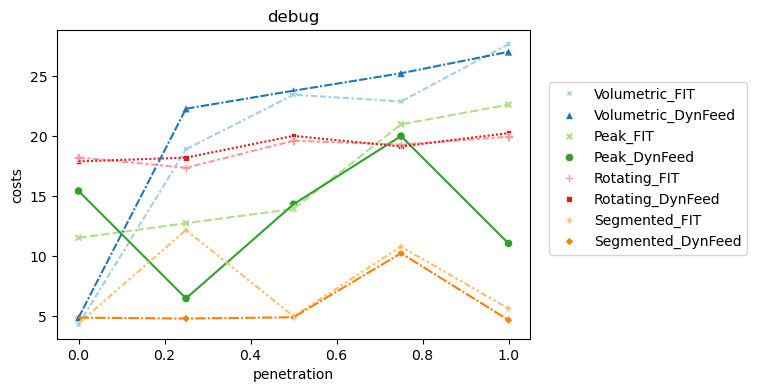

In [16]:
tmp = results_tmp.groupby(["tariff", "penetration", "mode"]).sum().reset_index()
hue_order = ['Volumetric_FIT', 'Volumetric_DynFeed', 'Peak_FIT', 'Peak_DynFeed', 
         'Rotating_FIT', 'Rotating_DynFeed', 'Segmented_FIT', 'Segmented_DynFeed']
colors_tmp = sns.color_palette("Paired")
img_size =(5.5,4)
fig, axes = plt.subplots(figsize=img_size)
mode = "debug"

x="penetration"
y="costs"
hue="tariff"

sns.lineplot(data=tmp.loc[(tmp["mode"]==mode)], x=x, y=y, hue=hue, hue_order = hue_order,
                        style=hue, palette=colors_tmp, ax=axes)

sns.scatterplot(data=tmp.loc[(tmp["mode"]==mode)], x=x, y=y, hue=hue, hue_order = hue_order,
                        style=hue, palette=colors_tmp, ax=axes)

plt.tight_layout()
h,l = axes.get_legend_handles_labels()
plt.title(mode)
axes.legend(h[8:], l[8:], loc="lower center", bbox_to_anchor=(1.25,0.25))

C:\Users\aheider\AppData\Local\Temp\ipykernel_13212\2509057926.py:13: UserWarning:

The palette list has more values (12) than needed (8), which may not be intended.

C:\Users\aheider\AppData\Local\Temp\ipykernel_13212\2509057926.py:16: UserWarning:

The palette list has more values (12) than needed (8), which may not be intended.



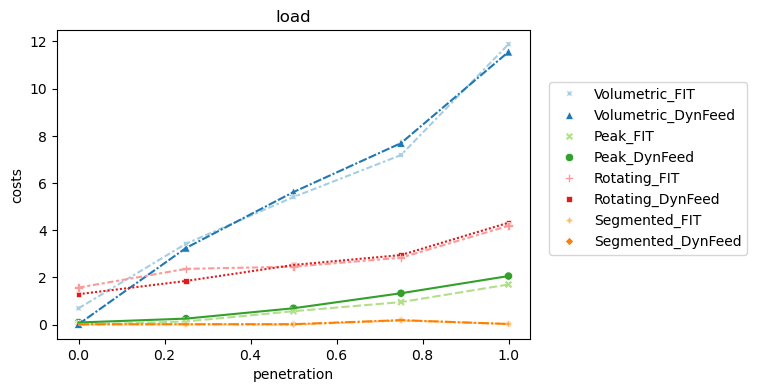

In [17]:
tmp = results_tmp.groupby(["tariff", "penetration", "mode"]).sum().reset_index()
hue_order = ['Volumetric_FIT', 'Volumetric_DynFeed', 'Peak_FIT', 'Peak_DynFeed', 
         'Rotating_FIT', 'Rotating_DynFeed', 'Segmented_FIT', 'Segmented_DynFeed']
colors_tmp = sns.color_palette("Paired")
img_size =(5.5,4)
fig, axes = plt.subplots(figsize=img_size)
mode = "load"

x="penetration"
y="costs"
hue="tariff"

sns.lineplot(data=tmp.loc[(tmp["mode"]==mode)], x=x, y=y, hue=hue, hue_order = hue_order,
                        style=hue, palette=colors_tmp, ax=axes)

sns.scatterplot(data=tmp.loc[(tmp["mode"]==mode)], x=x, y=y, hue=hue, hue_order = hue_order,
                        style=hue, palette=colors_tmp, ax=axes)

plt.tight_layout()
h,l = axes.get_legend_handles_labels()
plt.title(mode)
axes.legend(h[8:], l[8:], loc="lower center", bbox_to_anchor=(1.25,0.25))

C:\Users\aheider\AppData\Local\Temp\ipykernel_13212\863813965.py:13: UserWarning:

The palette list has more values (12) than needed (8), which may not be intended.

C:\Users\aheider\AppData\Local\Temp\ipykernel_13212\863813965.py:16: UserWarning:

The palette list has more values (12) than needed (8), which may not be intended.



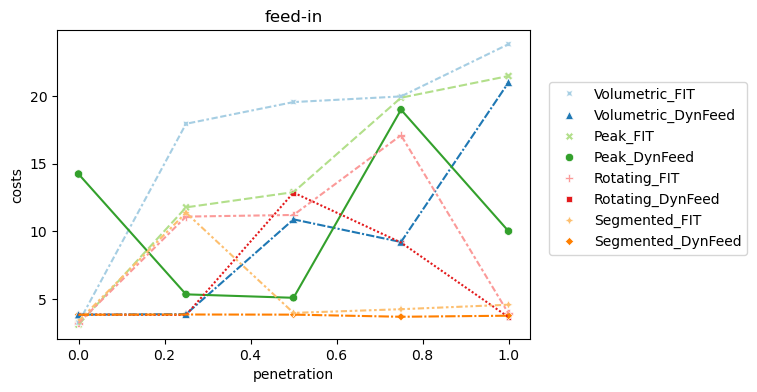

In [18]:
tmp = results_tmp.groupby(["tariff", "penetration", "mode"]).sum().reset_index()
hue_order = ['Volumetric_FIT', 'Volumetric_DynFeed', 'Peak_FIT', 'Peak_DynFeed', 
         'Rotating_FIT', 'Rotating_DynFeed', 'Segmented_FIT', 'Segmented_DynFeed']
colors_tmp = sns.color_palette("Paired")
img_size =(5.5,4)
fig, axes = plt.subplots(figsize=img_size)
mode = "feed-in"

x="penetration"
y="costs"
hue="tariff"

sns.lineplot(data=tmp.loc[(tmp["mode"]==mode)], x=x, y=y, hue=hue, hue_order = hue_order,
                        style=hue, palette=colors_tmp, ax=axes)

sns.scatterplot(data=tmp.loc[(tmp["mode"]==mode)], x=x, y=y, hue=hue, hue_order = hue_order,
                        style=hue, palette=colors_tmp, ax=axes)

plt.tight_layout()
h,l = axes.get_legend_handles_labels()
plt.title(mode)
axes.legend(h[8:], l[8:], loc="lower center", bbox_to_anchor=(1.25,0.25))

C:\Users\aheider\AppData\Local\Temp\ipykernel_13212\1235614821.py:13: UserWarning:


The palette list has fewer values (6) than needed (10) and will cycle, which may produce an uninterpretable plot.

C:\Users\aheider\AppData\Local\Temp\ipykernel_13212\1235614821.py:16: UserWarning:


The palette list has fewer values (6) than needed (10) and will cycle, which may produce an uninterpretable plot.



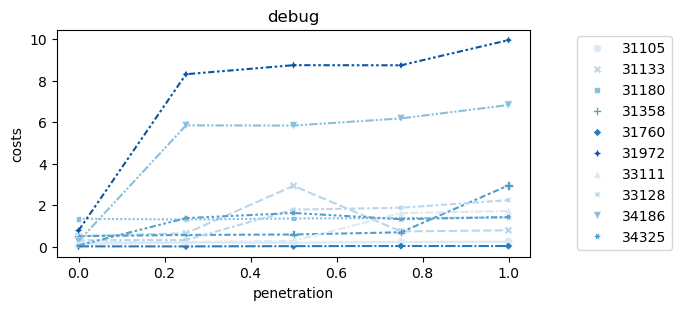

In [19]:
tmp = results_tmp.groupby(["tariff", "penetration", "mode", "grid_id"]).sum().reset_index()
hue_order = ['Volumetric_FIT', 'Volumetric_DynFeed', 'Peak_FIT', 'Peak_DynFeed', 
         'Rotating_FIT', 'Rotating_DynFeed', 'Segmented_FIT', 'Segmented_DynFeed']
colors_tmp = sns.color_palette("Blues")
img_size =(5.5,4)
fig, axes = plt.subplots(figsize=img_size)
mode = "debug"

x="penetration"
y="costs"
hue="grid_id"

sns.lineplot(data=tmp.loc[(tmp["mode"]==mode)&(tmp["tariff"]=='Volumetric_FIT')], x=x, y=y, hue=hue,
                        style=hue, palette=colors_tmp, ax=axes)

sns.scatterplot(data=tmp.loc[(tmp["mode"]==mode)&(tmp["tariff"]=='Volumetric_FIT')], x=x, y=y, hue=hue,
                        style=hue, palette=colors_tmp, ax=axes)

plt.tight_layout()
h,l = axes.get_legend_handles_labels()
plt.title(mode)
axes.legend(h[10:], l[10:], loc="lower center", bbox_to_anchor=(1.2,0.))

C:\Users\aheider\AppData\Local\Temp\ipykernel_13212\866077453.py:13: UserWarning:


The palette list has fewer values (6) than needed (10) and will cycle, which may produce an uninterpretable plot.

C:\Users\aheider\AppData\Local\Temp\ipykernel_13212\866077453.py:16: UserWarning:


The palette list has fewer values (6) than needed (10) and will cycle, which may produce an uninterpretable plot.



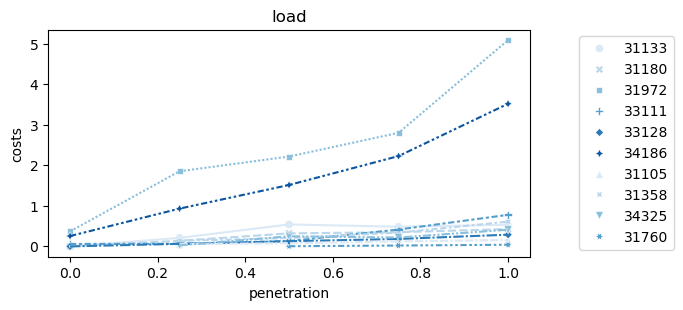

In [20]:
tmp = results_tmp.groupby(["tariff", "penetration", "mode", "grid_id"]).sum().reset_index()
hue_order = ['Volumetric_FIT', 'Volumetric_DynFeed', 'Peak_FIT', 'Peak_DynFeed', 
         'Rotating_FIT', 'Rotating_DynFeed', 'Segmented_FIT', 'Segmented_DynFeed']
colors_tmp = sns.color_palette("Blues")
img_size =(5.5,4)
fig, axes = plt.subplots(figsize=img_size)
mode = "load"

x="penetration"
y="costs"
hue="grid_id"

sns.lineplot(data=tmp.loc[(tmp["mode"]==mode)&(tmp["tariff"]=='Volumetric_FIT')], x=x, y=y, hue=hue,
                        style=hue, palette=colors_tmp, ax=axes)

sns.scatterplot(data=tmp.loc[(tmp["mode"]==mode)&(tmp["tariff"]=='Volumetric_FIT')], x=x, y=y, hue=hue,
                        style=hue, palette=colors_tmp, ax=axes)

plt.tight_layout()
h,l = axes.get_legend_handles_labels()
plt.title(mode)
axes.legend(h[10:], l[10:], loc="lower center", bbox_to_anchor=(1.2,0.))

C:\Users\aheider\AppData\Local\Temp\ipykernel_13212\2090929128.py:13: UserWarning:


The palette list has fewer values (6) than needed (10) and will cycle, which may produce an uninterpretable plot.

C:\Users\aheider\AppData\Local\Temp\ipykernel_13212\2090929128.py:16: UserWarning:


The palette list has fewer values (6) than needed (10) and will cycle, which may produce an uninterpretable plot.



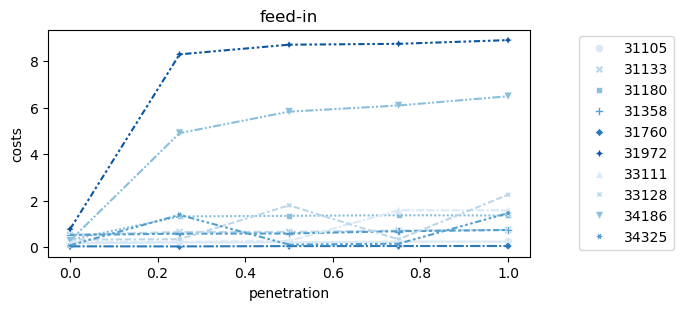

In [21]:
tmp = results_tmp.groupby(["tariff", "penetration", "mode", "grid_id"]).sum().reset_index()
hue_order = ['Volumetric_FIT', 'Volumetric_DynFeed', 'Peak_FIT', 'Peak_DynFeed', 
         'Rotating_FIT', 'Rotating_DynFeed', 'Segmented_FIT', 'Segmented_DynFeed']
colors_tmp = sns.color_palette("Blues")
img_size =(5.5,4)
fig, axes = plt.subplots(figsize=img_size)
mode = "feed-in"

x="penetration"
y="costs"
hue="grid_id"

sns.lineplot(data=tmp.loc[(tmp["mode"]==mode)&(tmp["tariff"]=='Volumetric_FIT')], x=x, y=y, hue=hue,
                        style=hue, palette=colors_tmp, ax=axes)

sns.scatterplot(data=tmp.loc[(tmp["mode"]==mode)&(tmp["tariff"]=='Volumetric_FIT')], x=x, y=y, hue=hue,
                        style=hue, palette=colors_tmp, ax=axes)

plt.tight_layout()
h,l = axes.get_legend_handles_labels()
plt.title(mode)
axes.legend(h[10:], l[10:], loc="lower center", bbox_to_anchor=(1.2,0.))

C:\Users\aheider\AppData\Local\Temp\ipykernel_13212\2887882169.py:29: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

C:\Users\aheider\AppData\Local\Temp\ipykernel_13212\2887882169.py:29: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

C:\Users\aheider\AppData\Local\Temp\ipykernel_13212\2887882169.py:29: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

C:\Users\aheider\AppData\Local\Temp\ipykernel_13212\2887882169.py:29: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

C:\Users\aheider\AppData\Local\Temp\ipykernel_13212\2887882169.py:29: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



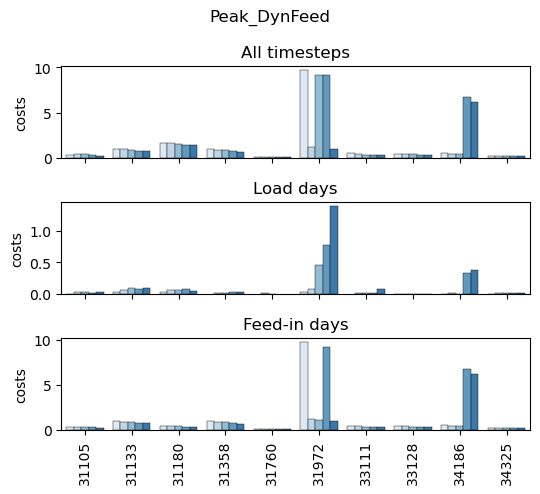

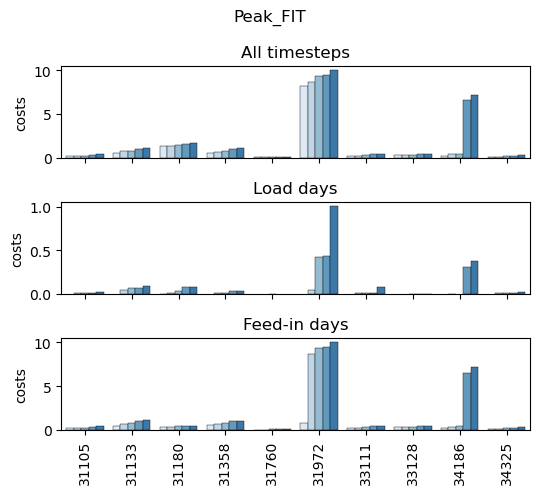

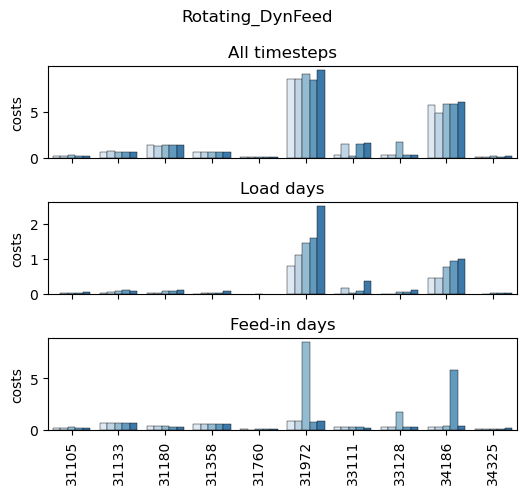

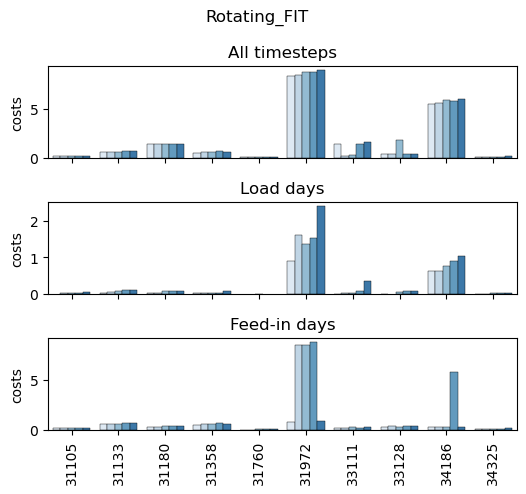

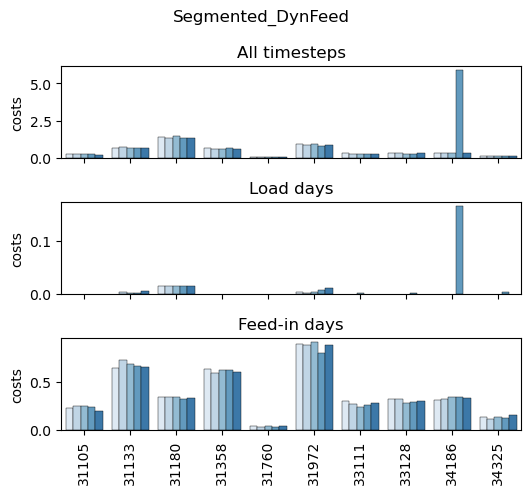

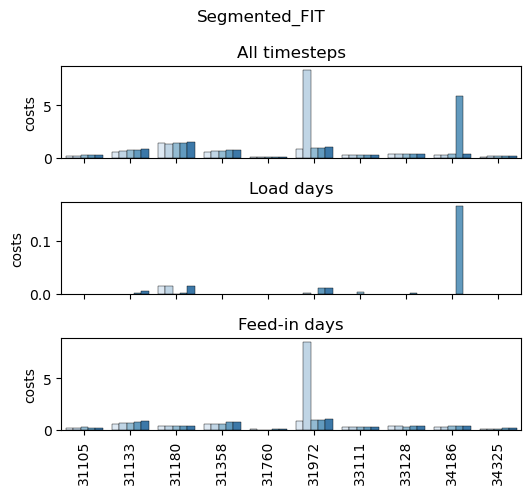

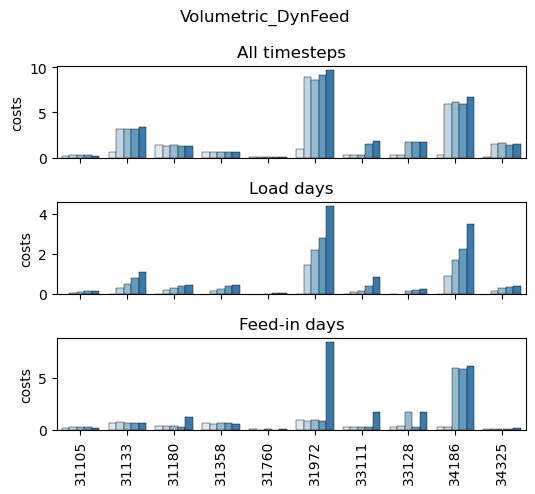

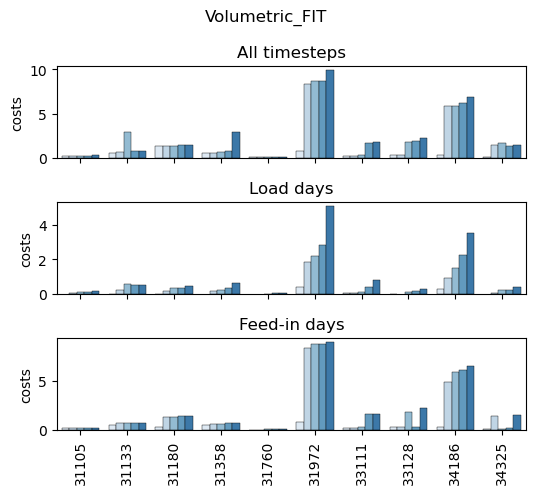

In [22]:
results = results_tmp.copy()
colors_tmp = sns.color_palette("Blues")[:5]
for tariff in tmp.tariff.unique():
    if tariff == "Base":
        continue
    img_size =(5.5,5)
    tmp = results.loc[results.tariff == tariff]
    fig, axes = plt.subplots(3, figsize=img_size)
    plt.suptitle(tariff)
    ax=axes[0]
    plot_df = tmp.loc[tmp["mode"]=="debug"]
    sns.barplot(data=plot_df, x="grid_id", hue="penetration", y="costs", palette=colors_tmp, ax=ax, 
                linewidth=0.3, edgecolor="k", legend=False, order=tmp.grid_id.unique())
    ax.set_xlabel("")
    ax.set_xticklabels([])
    ax.set_title("All timesteps")
    ax=axes[1]
    plot_df = tmp.loc[tmp["mode"]=="load"]
    sns.barplot(data=plot_df, x="grid_id", hue="penetration", y="costs", palette=colors_tmp, ax=ax, 
                linewidth=0.3, edgecolor="k", legend=False, order=tmp.grid_id.unique())
    ax.set_xlabel("")
    ax.set_xticklabels([])
    ax.set_title("Load days")
    ax=axes[2]
    plot_df = tmp.loc[tmp["mode"]=="feed-in"]
    sns.barplot(data=plot_df, x="grid_id", hue="penetration", y="costs", palette=colors_tmp, ax=ax, 
                linewidth=0.3, edgecolor="k", legend=False, order=tmp.grid_id.unique())
    ax.set_xlabel("")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_title("Feed-in days")
    plt.tight_layout()

In [70]:
tmp

,tariff,penetration,mode,grid_id,costs,costs_lv,costs_mv,costs_mvlv
0,Volumetric_FIT,0.00,debug,all,4.313541,3.263541,0.0,1.05
1,Volumetric_FIT,0.00,feed-in,all,3.244165,2.224165,0.0,1.02
2,Volumetric_FIT,0.00,load,all,0.693407,0.693407,0.0,0.00
3,Volumetric_FIT,0.25,debug,all,18.935184,17.705184,0.0,1.23
4,Volumetric_FIT,0.25,feed-in,all,17.934564,16.734564,0.0,1.20
5,Volumetric_FIT,0.25,load,all,3.430119,3.170119,0.0,0.26
6,Volumetric_FIT,0.50,debug,all,23.474889,22.224889,0.0,1.25
7,Volumetric_FIT,0.50,feed-in,all,19.538340,18.338340,0.0,1.20
8,Volumetric_FIT,0.50,load,all,5.406595,5.086595,0.0,0.32
9,Volumetric_FIT,0.75,debug,all,22.916760,21.566760,0.0,1.35


In [26]:
results_tmp

,grid_id,tariff,penetration,mode,costs,costs_lv,costs_mv,costs_mvlv,relative_costs_percent
0,31105,Peak_DynFeed,0.00,load,0.003723,0.003723,0.0,0.00,0.012054
0,31105,Peak_DynFeed,0.00,feed-in,0.358460,0.318460,0.0,0.04,1.160502
0,31105,Peak_DynFeed,0.00,debug,0.358460,0.318460,0.0,0.04,1.160502
0,31105,Peak_DynFeed,0.25,load,0.031141,0.031141,0.0,0.00,0.100817
0,31105,Peak_DynFeed,0.25,feed-in,0.363687,0.323687,0.0,0.04,1.177422
...,...,...,...,...,...,...,...,...,...
0,34325,Volumetric_FIT,0.75,feed-in,0.147768,0.127768,0.0,0.02,0.432587
0,34325,Volumetric_FIT,0.75,debug,1.338521,1.318521,0.0,0.02,3.918485
0,34325,Volumetric_FIT,1.00,load,0.413227,0.413227,0.0,0.00,1.209712
0,34325,Volumetric_FIT,1.00,feed-in,1.461251,1.431251,0.0,0.03,4.277774


C:\Users\aheider\AppData\Local\Temp\ipykernel_13212\1015795351.py:31: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

C:\Users\aheider\AppData\Local\Temp\ipykernel_13212\1015795351.py:31: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

C:\Users\aheider\AppData\Local\Temp\ipykernel_13212\1015795351.py:31: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

C:\Users\aheider\AppData\Local\Temp\ipykernel_13212\1015795351.py:31: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

C:\Users\aheider\AppData\Local\Temp\ipykernel_13212\1015795351.py:31: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



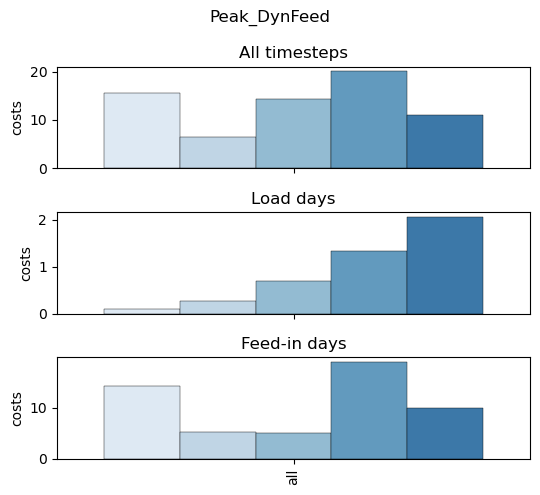

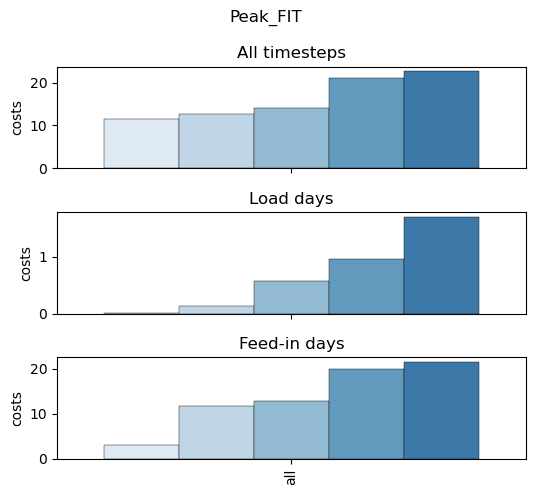

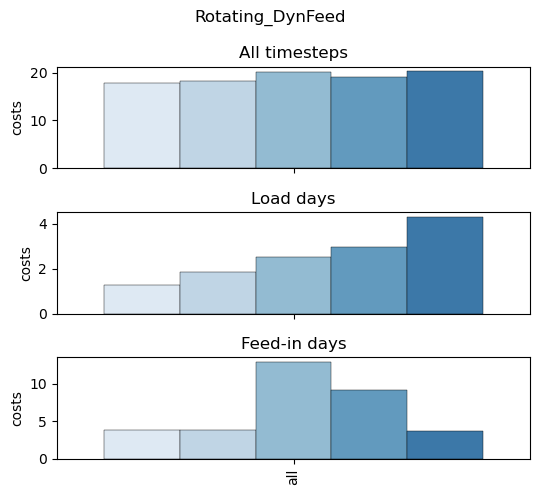

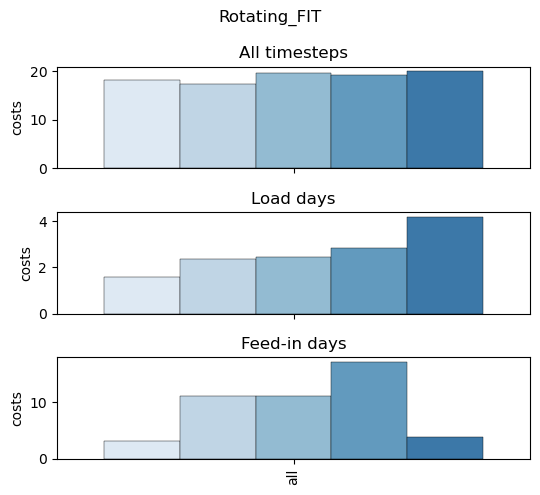

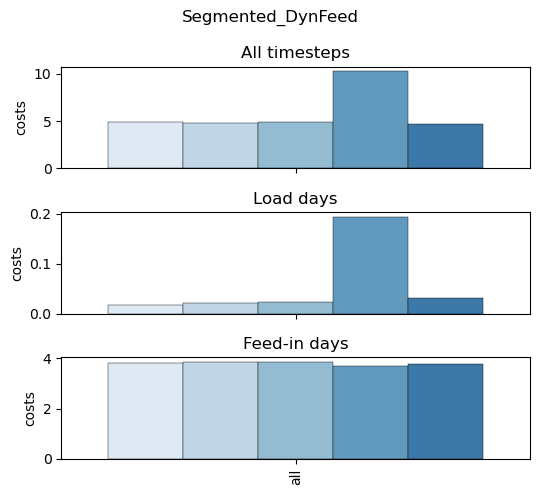

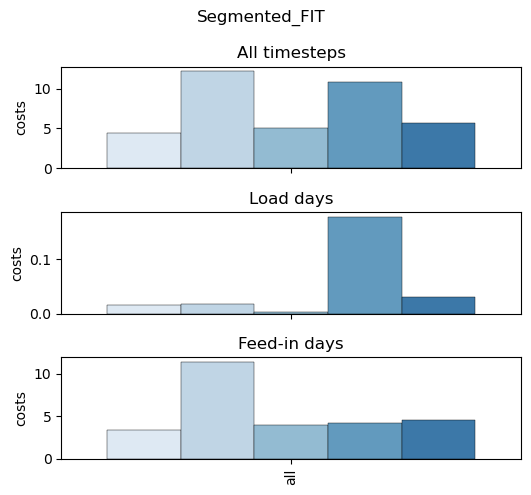

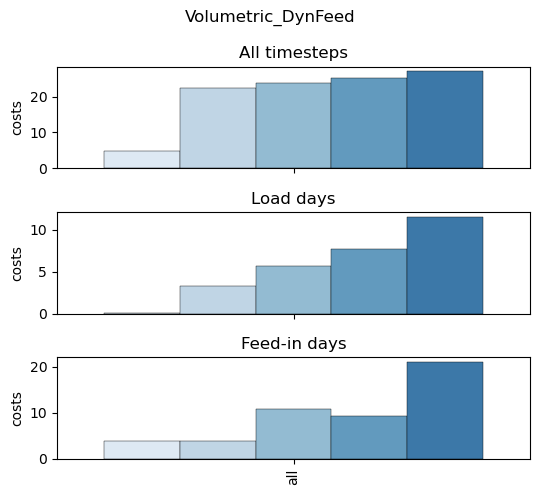

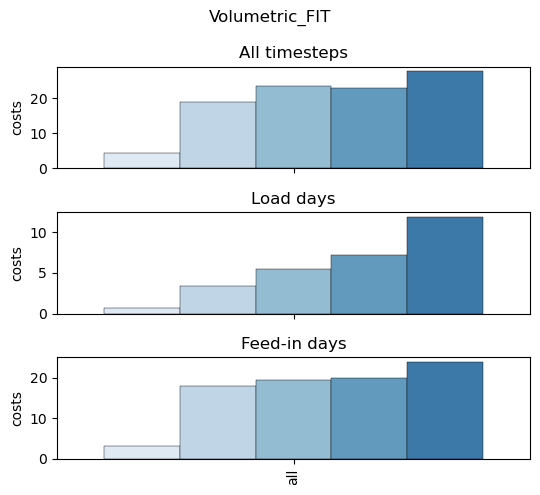

In [27]:
results = results_tmp.groupby(["tariff", "penetration", "mode"]).sum().reset_index()
results["grid_id"] = "all"
colors_tmp = sns.color_palette("Blues")[:5]
for tariff in results.tariff.unique():
    if tariff == "Base":
        continue
    img_size =(5.5,5)
    tmp = results.loc[results.tariff == tariff]
    fig, axes = plt.subplots(3, figsize=img_size)
    plt.suptitle(tariff)
    ax=axes[0]
    plot_df = tmp.loc[tmp["mode"]=="debug"]
    sns.barplot(data=plot_df, x="grid_id", hue="penetration", y="costs", palette=colors_tmp, ax=ax, 
                linewidth=0.3, edgecolor="k", legend=False, order=tmp.grid_id.unique())
    ax.set_xlabel("")
    ax.set_xticklabels([])
    ax.set_title("All timesteps")
    ax=axes[1]
    plot_df = tmp.loc[tmp["mode"]=="load"]
    sns.barplot(data=plot_df, x="grid_id", hue="penetration", y="costs", palette=colors_tmp, ax=ax, 
                linewidth=0.3, edgecolor="k", legend=False, order=tmp.grid_id.unique())
    ax.set_xlabel("")
    ax.set_xticklabels([])
    ax.set_title("Load days")
    ax=axes[2]
    plot_df = tmp.loc[tmp["mode"]=="feed-in"]
    sns.barplot(data=plot_df, x="grid_id", hue="penetration", y="costs", palette=colors_tmp, ax=ax, 
                linewidth=0.3, edgecolor="k", legend=False, order=tmp.grid_id.unique())
    ax.set_xlabel("")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_title("Feed-in days")
    plt.tight_layout()

In [33]:
# load constant costs
costs_constant_all = pd.read_csv(os.path.join("output", "costs_inflexible.csv"), index_col=0)
costs_constant_all

,costs,costs_lv,costs_mv,costs_mvlv
mode,,,,
debug,19.461506,17.941506,0.0,1.52
feed-in,13.212788,11.692788,0.0,1.52
load,0.773976,0.773976,0.0,0.00


C:\Users\aheider\AppData\Local\Temp\ipykernel_13212\1920374608.py:13: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\aheider\AppData\Local\Temp\ipykernel_13212\1920374608.py:13: UserWarning:

The palette list has more values (12) than needed (8), which may not be intended.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\aheider\AppData\Local\Temp\ipykernel_13212\1920374608.py:13: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\aheider\AppData\Local\Temp\ipykernel_13212\1920374608.py:13: UserWarning:

The palette list has more values (12) than needed (8), which may not be intended.


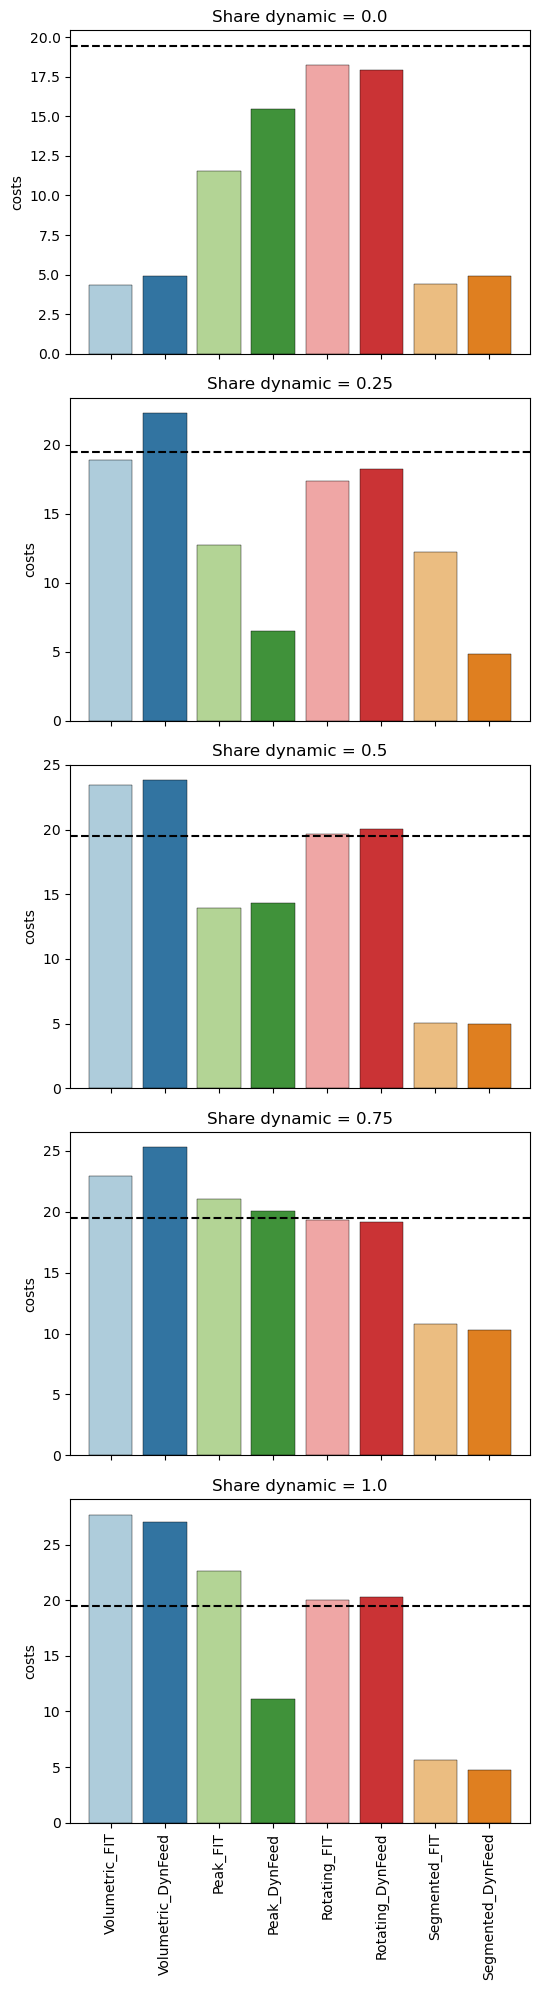

In [35]:
tmp = results_tmp.groupby(["tariff", "penetration", "mode"]).sum().reset_index()
order = ['Volumetric_FIT', 'Volumetric_DynFeed', 'Peak_FIT', 'Peak_DynFeed', 
         'Rotating_FIT', 'Rotating_DynFeed', 'Segmented_FIT', 'Segmented_DynFeed']
colors_tmp = sns.color_palette("Paired")
img_size =(5.5,20)
fig, axes = plt.subplots(5, figsize=img_size)
mode = "debug"
costs_constant = costs_constant_all.loc[mode, "costs"]

for idx, share_dyn in enumerate(penetrations):
    ax=axes[idx]
    plot_df = tmp.loc[(tmp["mode"]==mode)&(tmp.penetration==share_dyn)]
    sns.barplot(data=plot_df, x="tariff", y="costs", palette=colors_tmp, ax=ax, linewidth=0.3, edgecolor="k", order=order)
    ax.hlines(y=costs_constant, xmin=-0.75, xmax=7.75, color="k", linestyle="--")
    ax.set_xlabel("")
    ax.set_xlim(-0.75,7.75)
    if idx < 4:
        ax.set_xticklabels([])
    else:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_title(f"Share dynamic = {share_dyn}")
    ax.legend().remove()
plt.tight_layout()

C:\Users\aheider\AppData\Local\Temp\ipykernel_13212\3237135424.py:15: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\aheider\AppData\Local\Temp\ipykernel_13212\3237135424.py:15: UserWarning:

The palette list has more values (12) than needed (8), which may not be intended.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\aheider\AppData\Local\Temp\ipykernel_13212\3237135424.py:15: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\aheider\AppData\Local\Temp\ipykernel_13212\3237135424.py:15: UserWarning:

The palette list has more values (12) than needed (8), which may not be intended.


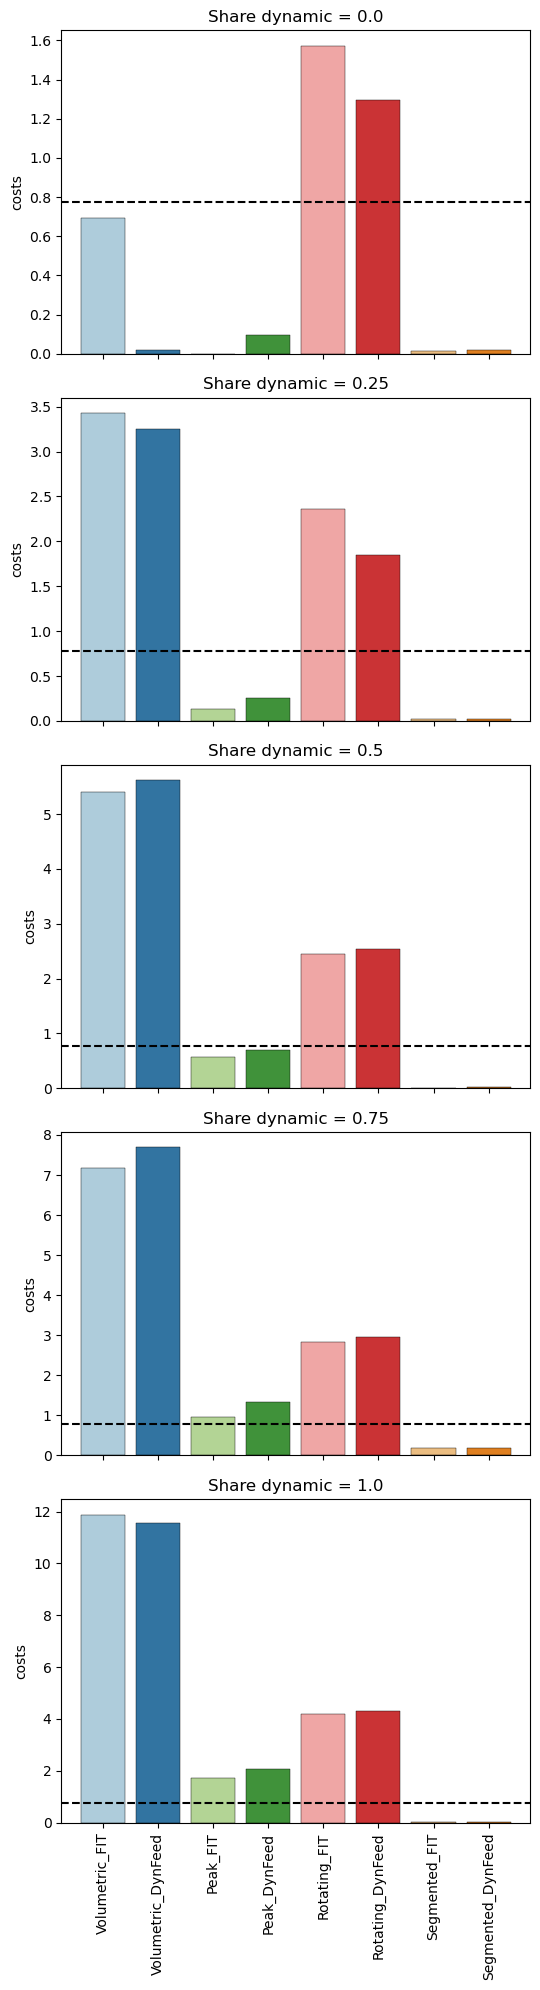

In [36]:
tmp = results_tmp.groupby(["tariff", "penetration", "mode"]).sum().reset_index()
order = ['Volumetric_FIT', 'Volumetric_DynFeed', 'Peak_FIT', 'Peak_DynFeed', 
         'Rotating_FIT', 'Rotating_DynFeed', 'Segmented_FIT', 'Segmented_DynFeed']
colors_tmp = sns.color_palette("Paired")
img_size =(5.5,20)
fig, axes = plt.subplots(5, figsize=img_size)
mode = "load"
costs_constant = costs_constant_all.loc[mode, "costs"]

for idx, share_dyn in enumerate(penetrations):
    ax=axes[idx]
    plot_df = tmp.loc[(tmp["mode"]==mode)&(tmp.penetration==share_dyn)]
    sns.barplot(data=plot_df, x="tariff", y="costs", palette=colors_tmp, ax=ax, linewidth=0.3, edgecolor="k", order=order)
    ax.hlines(y=costs_constant, xmin=-0.75, xmax=7.75, color="k", linestyle="--")
    ax.set_xlabel("")
    ax.set_xlim(-0.75,7.75)
    if idx < 4:
        ax.set_xticklabels([])
    else:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_title(f"Share dynamic = {share_dyn}")
    ax.legend().remove()
plt.tight_layout()

C:\Users\aheider\AppData\Local\Temp\ipykernel_13212\2659254411.py:15: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\aheider\AppData\Local\Temp\ipykernel_13212\2659254411.py:15: UserWarning:

The palette list has more values (12) than needed (8), which may not be intended.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\aheider\AppData\Local\Temp\ipykernel_13212\2659254411.py:15: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\aheider\AppData\Local\Temp\ipykernel_13212\2659254411.py:15: UserWarning:

The palette list has more values (12) than needed (8), which may not be intended.


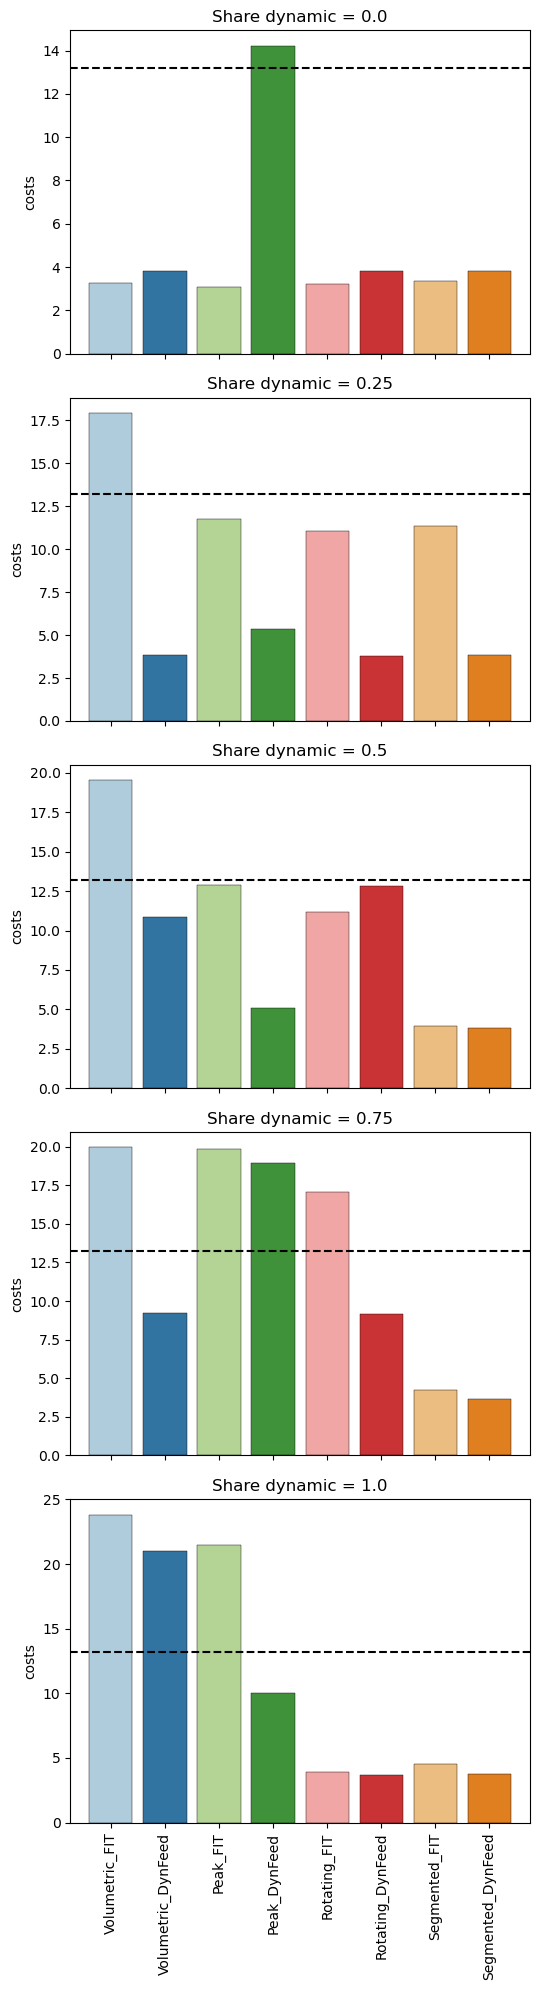

In [37]:
# Todo: in the end add up all grids

tmp = results_tmp.groupby(["tariff", "penetration", "mode"]).sum().reset_index()
order = ['Volumetric_FIT', 'Volumetric_DynFeed', 'Peak_FIT', 'Peak_DynFeed', 
         'Rotating_FIT', 'Rotating_DynFeed', 'Segmented_FIT', 'Segmented_DynFeed']
colors_tmp = sns.color_palette("Paired")
img_size =(5.5,20)
fig, axes = plt.subplots(5, figsize=img_size)
mode = "feed-in"
costs_constant = costs_constant_all.loc[mode, "costs"]

for idx, share_dyn in enumerate(penetrations):
    ax=axes[idx]
    plot_df = tmp.loc[(tmp["mode"]==mode)&(tmp.penetration==share_dyn)]
    sns.barplot(data=plot_df, x="tariff", y="costs", palette=colors_tmp, ax=ax, linewidth=0.3, edgecolor="k", order=order)
    ax.hlines(y=costs_constant, xmin=-0.75, xmax=7.75, color="k", linestyle="--")
    ax.set_xlabel("")
    ax.set_xlim(-0.75,7.75)
    if idx < 4:
        ax.set_xticklabels([])
    else:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_title(f"Share dynamic = {share_dyn}")
    ax.legend().remove()
plt.tight_layout()

# Results relative values

In [38]:
results_tmp

,grid_id,tariff,penetration,mode,costs,costs_lv,costs_mv,costs_mvlv,relative_costs_percent
0,31105,Peak_DynFeed,0.00,load,0.003723,0.003723,0.0,0.00,0.012054
0,31105,Peak_DynFeed,0.00,feed-in,0.358460,0.318460,0.0,0.04,1.160502
0,31105,Peak_DynFeed,0.00,debug,0.358460,0.318460,0.0,0.04,1.160502
0,31105,Peak_DynFeed,0.25,load,0.031141,0.031141,0.0,0.00,0.100817
0,31105,Peak_DynFeed,0.25,feed-in,0.363687,0.323687,0.0,0.04,1.177422
...,...,...,...,...,...,...,...,...,...
0,34325,Volumetric_FIT,0.75,feed-in,0.147768,0.127768,0.0,0.02,0.432587
0,34325,Volumetric_FIT,0.75,debug,1.338521,1.318521,0.0,0.02,3.918485
0,34325,Volumetric_FIT,1.00,load,0.413227,0.413227,0.0,0.00,1.209712
0,34325,Volumetric_FIT,1.00,feed-in,1.461251,1.431251,0.0,0.03,4.277774


In [39]:
relevant_results = ["tariff", "penetration", "mode", "costs","relative_costs_percent"]
results_tmp[relevant_results].groupby(
    ["tariff", "penetration", "mode"]).mean().reset_index()

,tariff,penetration,mode,costs,relative_costs_percent
0,Peak_DynFeed,0.00,debug,1.545472,2.621784
1,Peak_DynFeed,0.00,feed-in,1.422306,2.330315
2,Peak_DynFeed,0.00,load,0.013393,0.025684
3,Peak_DynFeed,0.25,debug,0.650375,1.462252
4,Peak_DynFeed,0.25,feed-in,0.533376,1.185379
...,...,...,...,...,...
115,Volumetric_FIT,0.75,feed-in,1.995580,3.570353
116,Volumetric_FIT,0.75,load,0.718549,1.311563
117,Volumetric_FIT,1.00,debug,2.769135,5.160708
118,Volumetric_FIT,1.00,feed-in,2.381616,4.447568


C:\Users\aheider\AppData\Local\Temp\ipykernel_13212\1480185579.py:15: UserWarning:

The palette list has more values (12) than needed (8), which may not be intended.

C:\Users\aheider\AppData\Local\Temp\ipykernel_13212\1480185579.py:18: UserWarning:

The palette list has more values (12) than needed (8), which may not be intended.



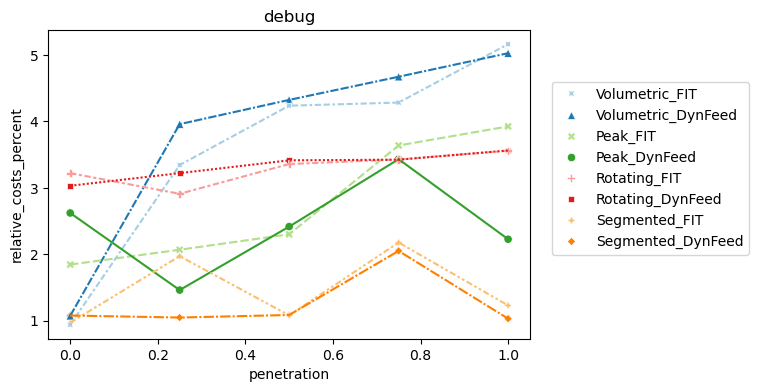

In [40]:
relevant_results = ["tariff", "penetration", "mode", "costs","relative_costs_percent"]
tmp = results_tmp[relevant_results].groupby(
    ["tariff", "penetration", "mode"]).mean().reset_index()
hue_order = ['Volumetric_FIT', 'Volumetric_DynFeed', 'Peak_FIT', 'Peak_DynFeed', 
         'Rotating_FIT', 'Rotating_DynFeed', 'Segmented_FIT', 'Segmented_DynFeed']
colors_tmp = sns.color_palette("Paired")
img_size =(5.5,4)
fig, axes = plt.subplots(figsize=img_size)
mode = "debug"

x="penetration"
y="relative_costs_percent"
hue="tariff"

sns.lineplot(data=tmp.loc[(tmp["mode"]==mode)], x=x, y=y, hue=hue, hue_order = hue_order,
                        style=hue, palette=colors_tmp, ax=axes)

sns.scatterplot(data=tmp.loc[(tmp["mode"]==mode)], x=x, y=y, hue=hue, hue_order = hue_order,
                        style=hue, palette=colors_tmp, ax=axes)

plt.tight_layout()
h,l = axes.get_legend_handles_labels()
plt.title(mode)
axes.legend(h[8:], l[8:], loc="lower center", bbox_to_anchor=(1.25,0.25))

C:\Users\aheider\AppData\Local\Temp\ipykernel_13212\1079699701.py:13: UserWarning:


The palette list has fewer values (6) than needed (10) and will cycle, which may produce an uninterpretable plot.

C:\Users\aheider\AppData\Local\Temp\ipykernel_13212\1079699701.py:16: UserWarning:


The palette list has fewer values (6) than needed (10) and will cycle, which may produce an uninterpretable plot.



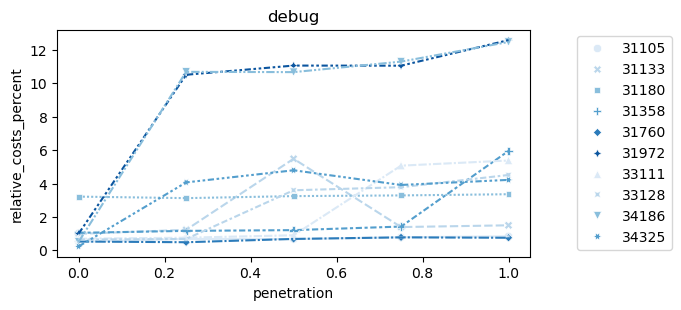

In [41]:
tmp = results_tmp.groupby(["tariff", "penetration", "mode", "grid_id"]).mean().reset_index()
hue_order = ['Volumetric_FIT', 'Volumetric_DynFeed', 'Peak_FIT', 'Peak_DynFeed', 
         'Rotating_FIT', 'Rotating_DynFeed', 'Segmented_FIT', 'Segmented_DynFeed']
colors_tmp = sns.color_palette("Blues")
img_size =(5.5,4)
fig, axes = plt.subplots(figsize=img_size)
mode = "debug"

x="penetration"
y="relative_costs_percent"
hue="grid_id"

sns.lineplot(data=tmp.loc[(tmp["mode"]==mode)&(tmp["tariff"]=='Volumetric_FIT')], x=x, y=y, hue=hue,
                        style=hue, palette=colors_tmp, ax=axes)

sns.scatterplot(data=tmp.loc[(tmp["mode"]==mode)&(tmp["tariff"]=='Volumetric_FIT')], x=x, y=y, hue=hue,
                        style=hue, palette=colors_tmp, ax=axes)

plt.tight_layout()
h,l = axes.get_legend_handles_labels()
plt.title(mode)
axes.legend(h[10:], l[10:], loc="lower center", bbox_to_anchor=(1.2,0.))